# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


##### 사내 서버 경로

In [3]:
import os
os.getcwd()
os.chdir('/root/data/highkh/cs231n/highkh/assignment1')

In [4]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## CIFAR-10 Data Loading and Preprocessing

In [5]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print 'Training data shape: ', X_train.shape
print 'Training labels shape: ', y_train.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


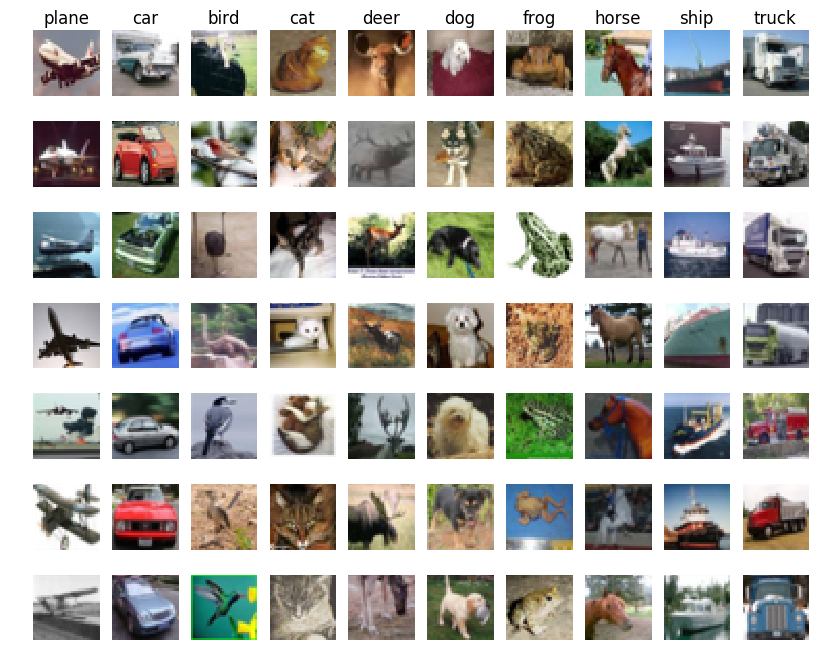

In [6]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

#### training + validation = 49000 + 1000 = 50000
#### test = 1000 / 10000
#### devlopment = random500 / 50000

In [7]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print 'Train data shape: ', X_train.shape
print 'Train labels shape: ', y_train.shape
print 'Validation data shape: ', X_val.shape
print 'Validation labels shape: ', y_val.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [8]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print 'Training data shape: ', X_train.shape
print 'Validation data shape: ', X_val.shape
print 'Test data shape: ', X_test.shape
print 'dev data shape: ', X_dev.shape

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[ 130.64189796  135.98173469  132.47391837  130.05569388  135.34804082
  131.75402041  130.96055102  136.14328571  132.47636735  131.48467347]


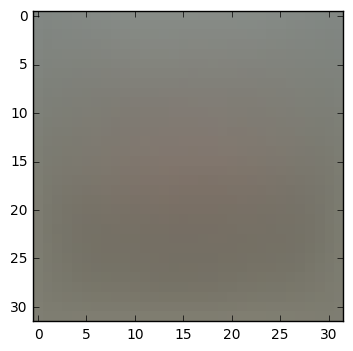

In [9]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print mean_image[:10] # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

#### 이미지의 평균 = 대부분 회색(130' : 0~255의 중간쯤)
#### CLT의 한가지 예로 봐도 되려나 모르겠다
#### subtract mean of the TRAIN
#### 훈련용 평균으로 나머지도 다 빼준다. 각각의 평균을 따로 구해서 사용하면 안됨!
#### 훈련용으로 구한 분류기로 검증 및 테스트에 사용할 것이기 때문에.....

In [10]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

#### $WX + b = W'X'$ where $W' = [W | b] , X' = [X | 1]$

In [11]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print X_train.shape, X_val.shape, X_test.shape, X_dev.shape

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## SVM Classifier

Your code for this section will all be written inside **cs231n/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [14]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)
print 'loss: %f' % (loss, )
print 'grad: ' , grad

loss_reg, grad_reg = svm_loss_naive(W, X_dev, y_dev, 0.00001)
print 'loss_reg: %f' % (loss_reg, )
print 'grad_reg: ' , grad_reg

loss: 8.878939
grad:  [[ -2.57791209e+01   7.93894718e+00   1.60642972e+01 ...,  -8.62367592e+00
   -2.63396884e+01  -1.23769597e+01]
 [ -3.59663014e+01   1.16622739e+01   1.62742192e+01 ...,  -1.09992694e+01
   -3.44562284e+01  -1.99212329e+01]
 [ -5.62942863e+01   1.22586793e+01   2.64203130e+01 ...,  -6.32295673e+00
   -5.62141820e+01  -3.96979046e+01]
 ..., 
 [ -1.76533931e+01   4.65839673e-01  -8.39234351e+00 ...,  -1.77544784e+01
    5.24715902e+00  -1.76420229e+00]
 [ -3.42436540e+01  -1.36484874e+01   7.50320514e+00 ...,  -2.35598286e+00
   -1.75452523e+01  -7.67078200e+00]
 [ -1.26000000e-01  -2.04000000e-01   1.20000000e-02 ...,   4.00000000e-02
   -1.22000000e-01   4.20000000e-02]]
loss_reg: 8.878939
grad_reg:  [[ -2.57791209e+01   7.93894718e+00   1.60642972e+01 ...,  -8.62367592e+00
   -2.63396884e+01  -1.23769597e+01]
 [ -3.59663014e+01   1.16622739e+01   1.62742192e+01 ...,  -1.09992694e+01
   -3.44562284e+01  -1.99212329e+01]
 [ -5.62942863e+01   1.22586793e+01   2.6420

#### loss값이 9정도가 나오는 것이 정상
#### CIFAR10의 class가 10개이고, 임의의 input이 해당 label과 맞아 떨어질 확률은 10%
#### 다시 말해 다를 확률이 90%이므로 다른 것들과의 class 차이 개수가 loss에 반영이 되기 때문에
#### 10개중에 9개가 다른 것이므로 loss가 9정도가 나오는 것임

The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [15]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

print "--------------------- without regularization -------------------------"
# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)
# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

print "--------------------- regularization 0.01 -------------------------"

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 1e-2)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 1e-2)[0]
grad_numerical = grad_check_sparse(f, W, grad)


print "--------------------- regularization 100 -------------------------"

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 1e2)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad)

--------------------- without regularization -------------------------
numerical: -19.867731	 analytic: -19.867731	 relative error: 1.047115e-11	 absolute error: 4.160761e-10
numerical: 11.767399	 analytic: 11.767399	 relative error: 1.348933e-11	 absolute error: 3.174687e-10
numerical: -23.711408	 analytic: -23.711408	 relative error: 2.500162e-12	 absolute error: 1.185647e-10
numerical: -0.499906	 analytic: -0.499906	 relative error: 7.718929e-10	 absolute error: 7.717470e-10
numerical: 3.592034	 analytic: 3.592034	 relative error: 4.188895e-11	 absolute error: 3.009331e-10
numerical: 8.921851	 analytic: 8.921851	 relative error: 1.698538e-11	 absolute error: 3.030820e-10
numerical: 12.983578	 analytic: 12.983578	 relative error: 9.916331e-12	 absolute error: 2.574989e-10
numerical: -3.745363	 analytic: -3.745363	 relative error: 1.127598e-10	 absolute error: 8.446528e-10
numerical: 3.658712	 analytic: 3.658712	 relative error: 9.098719e-11	 absolute error: 6.657919e-10
numerical: -0

#### numerical gradient와 analytic gradient를 비교
#### gradient_check.py에 absolute error도 볼 수 있게 수정
#### gradient_check.py에 구현된 numerical gradient의 경우 central scheme사용

### Inline Question 1:
It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? *Hint: the SVM loss function is not strictly speaking differentiable*

**Your Answer:**

SVM loss = $L_i = \sum_{j \neq y_i} \max{(0, w_j^T x_i - w_{y_i}^T x_i + \Delta)}$ 

$w_j^T x_i - w_{y_i}^T x_i + \Delta = 0$ 인 지점에서 미분 불가능(정확히는 그래프가 꺾이는 지점)

해당 지점의 도함수를 어떻게 정의 했냐에 따라서 gradient가 바뀌게 된다.

numerical gradient의 경우에는 forward라면 $w_j^T x_i - w_{y_i}^T x_i + \Delta$ 의 도함수, backward라면 0 , central의 경우 $(w_j^T x_i - w_{y_i}^T x_i + \Delta) / 2 $ 의 도함수

analytic gradient의 경우에는 0에서 subgradient 중에서 하나.

꺾이는 지점에서의 미분은 같게 만들 수 있으나, step size = h 에 따라서 꺾이는 지점 주변지점의 numerical gradient는 analytic과 차이가 생길 수 밖에 없다.

**loss가 꺾이는 지점의 미분값을 알아보고 싶은데 손을 못대겠음....**

In [24]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'Naive loss: %e computed in %fs' % (loss_naive, toc - tic)

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic)

# The losses should match but your vectorized implementation should be much faster.
print 'difference: %f' % (loss_naive - loss_vectorized)

Naive loss: 8.878939e+00 computed in 0.137103s
scr [[-0.00608345  0.03439292 -0.32859998 ...,  0.16336309 -0.11109622
   0.00240522]
 [-0.31232822 -0.18842706  0.18249755 ..., -0.00577165  0.06912738
   0.00161837]
 [ 0.02386704 -0.25696918 -0.39100961 ..., -0.49930976 -0.00356457
  -0.74102082]
 ..., 
 [ 0.52593836 -0.36622823 -0.49047648 ...,  0.75711471  0.44335886
   0.41578148]
 [ 0.31937572 -0.19816554 -0.56565057 ..., -0.04856393  0.22571398
  -0.35160487]
 [-0.06120159 -0.6076086  -0.92549734 ...,  0.47139174  0.1125279
  -0.4708209 ]] 500 10
y [0 2 0 4 5 0 9 5 6 4 7 7 4 2 2 0 6 0 7 0 2 5 1 9 6 1 8 8 7 6 1 8 2 2 7 6 8
 2 1 1 6 4 1 0 7 1 4 3 5 6 3 0 0 4 5 1 6 5 2 2 4 5 5 4 1 1 3 2 9 2 7 9 7 1
 1 5 0 7 1 4 2 7 8 2 4 4 0 8 6 9 0 7 4 3 0 8 4 1 2 5 1 7 5 1 5 1 8 8 8 3 6
 4 2 8 5 3 3 2 9 5 3 1 4 0 6 3 7 4 8 0 6 0 2 0 8 3 8 9 7 4 6 7 9 6 3 5 3 0
 5 2 9 9 3 1 0 0 9 5 1 9 2 1 0 1 4 4 9 5 8 2 1 6 6 2 5 7 5 4 0 9 8 7 1 3 0
 1 1 7 8 7 4 1 0 7 1 8 7 2 2 6 1 8 2 8 8 9 7 0 0 4 9 2 2 2 8 9 7 5

#### Loss Naive ver vs. Vec'ed ver $\Rightarrow$ Vector version이 약 5배 정도 빠름

In [13]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'Naive loss and gradient: computed in %fs' % (toc - tic)

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'Vectorized loss and gradient: computed in %fs' % (toc - tic)

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print 'difference: %f' % difference

Naive loss and gradient: computed in 0.067199s
Vectorized loss and gradient: computed in 0.007813s
difference: 0.000000


#### Gradient Naive ver vs. Vec'ed ver $\Rightarrow$ Vector version이 약 9배 정도 빠름

### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [14]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print 'That took %fs' % (toc - tic)

-----------learning_rate : 1.000000e-07	 reg : 5.000000e+04----------
iteration 0 / 1500: loss 792.813647
iteration 100 / 1500: loss 290.301893
iteration 200 / 1500: loss 109.139419
iteration 300 / 1500: loss 42.409059
iteration 400 / 1500: loss 19.313839
iteration 500 / 1500: loss 10.196848
iteration 600 / 1500: loss 7.531232
iteration 700 / 1500: loss 5.358165
iteration 800 / 1500: loss 4.910100
iteration 900 / 1500: loss 5.281188
iteration 1000 / 1500: loss 5.295316
iteration 1100 / 1500: loss 5.463569
iteration 1200 / 1500: loss 4.911818
iteration 1300 / 1500: loss 5.261567
iteration 1400 / 1500: loss 5.242395
That took 4.134507s


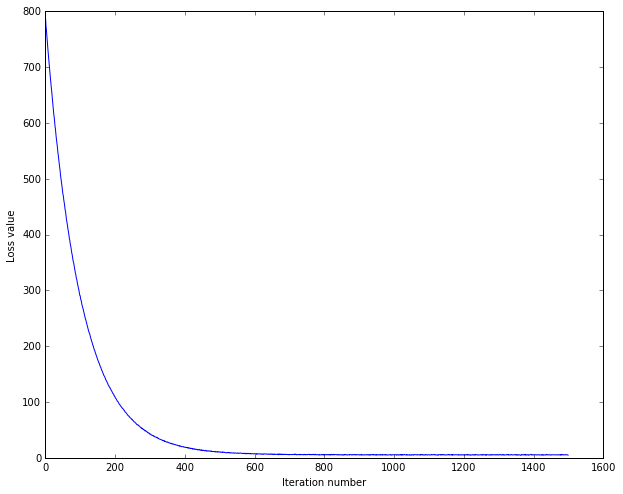

In [15]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [16]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print 'training accuracy: %f' % (np.mean(y_train == y_train_pred), )
y_val_pred = svm.predict(X_val)
print 'validation accuracy: %f' % (np.mean(y_val == y_val_pred), )

training accuracy: 0.372143
validation accuracy: 0.380000


In [17]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
#learning_rates = [1e-7, 5e-5]
#regularization_strengths = [5e4, 1e5]

learning_rates = [7e-8, 5e-7]
regularization_strengths = [1e4, 5e4]

rand_num = 36

rand_learning_rates = []
rand_regularization_strengths = []

for i in xrange(rand_num):
    rand_learning_rates.append(random.uniform(learning_rates[0], learning_rates[1]))
    rand_regularization_strengths.append(random.uniform(regularization_strengths[0], regularization_strengths[1]))
random.shuffle(rand_learning_rates)
random.shuffle(rand_regularization_strengths)
print 'picked lr = ', rand_learning_rates
print 'picked rg = ', rand_regularization_strengths

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################

rand_iter = 1
for lr, rg in zip(rand_learning_rates, rand_regularization_strengths):
    
    print 'rand iter = %d / %d' % (rand_iter, rand_num)
    bh_svm = LinearSVM()
    loss_hist = bh_svm.train(X_train, y_train, learning_rate=lr, reg=rg,
                  num_iters=2000, verbose=True)
    y_train_pred = bh_svm.predict(X_train)
    y_val_pred = bh_svm.predict(X_val)
    train_acc = np.mean(y_train == y_train_pred)
    val_acc = np.mean(y_val == y_val_pred)
    results[(lr, rg)] = (train_acc, val_acc)
        
    if val_acc > best_val:
        best_val = val_acc
        best_svm = bh_svm
    rand_iter += 1

################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

picked lr =  [2.5926581864850054e-07, 3.989023898365681e-07, 3.27843277637127e-07, 1.2455772485359592e-07, 3.453423623557484e-07, 2.1057746488382492e-07, 1.261673777187897e-07, 4.012833564558294e-07, 1.0956404734279982e-07, 1.7937113414351942e-07, 3.71944578697761e-07, 1.7974810883139672e-07, 3.7155981118800783e-07, 1.2166534405539675e-07, 3.5941389368346294e-07, 3.474323656548595e-07, 4.7487320631382857e-07, 1.2207118187311847e-07, 9.26590668829895e-08, 2.732381293151192e-07, 2.3350767957728183e-07, 1.9322119336495978e-07, 1.7723999136111205e-07, 4.992428533580342e-07, 4.564918706466926e-07, 3.80768411909827e-07, 8.1057055474158e-08, 2.421477813645257e-07, 2.2586735962202452e-07, 2.666284327343939e-07, 1.627838214477026e-07, 2.1455911973225402e-07, 2.1116578117334646e-07, 2.792120188083063e-07, 2.6233363028961357e-07, 2.4005587149230555e-07]
picked rg =  [25767.64233824625, 16241.952984958301, 33610.29599160141, 31559.285361594648, 18251.84973382188, 46658.70853930586, 46378.864117694

#### 수업시간에 배운대로 grid 형태의 uniform sampling이 아닌, 각각의 parameter에 대하여 random sampling을 하였음
#### 아래 그래프를 통하여 축에 상관없이 random하게 sampling된 것을 볼 수 있다.
#### 40% valid accuracy를 얻기 위하여 sample point와 learning rate/reg strength interval를 많이 조절해 봐야함
#### iteration number도 1500에서 2000으로 늘림

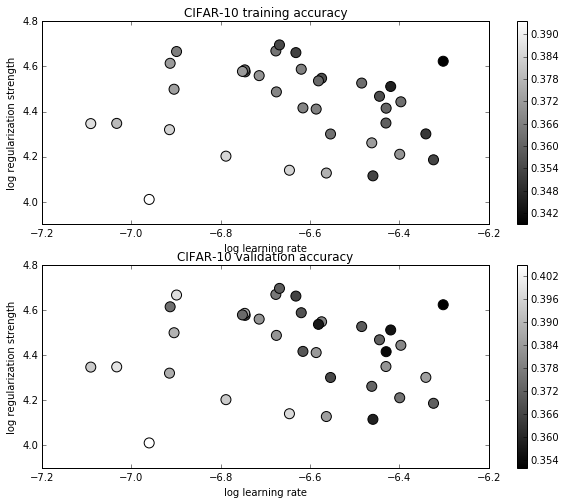

In [18]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [19]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print 'linear SVM on raw pixels final test set accuracy: %f' % test_accuracy

linear SVM on raw pixels final test set accuracy: 0.384000


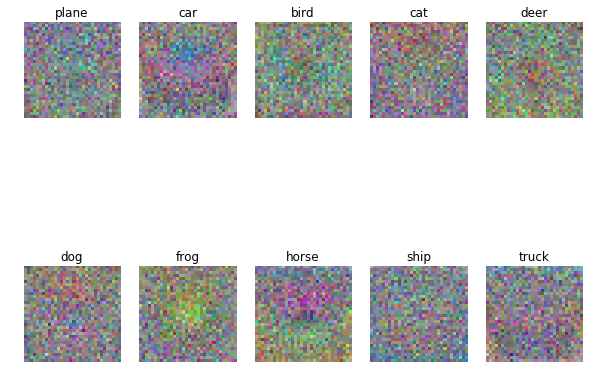

In [20]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in xrange(10):
  plt.subplot(2, 5, i + 1)
    
  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])

### Inline question 2:
Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

**Your answer:**
뭔가 알아보기 힘들게 나왔음;;;;
어쩌다 알아보기 괜찮은 결과들이 나올때가 있는데(전체 code를 실행할 때 마다 이미지가 다르게 나와서 그런듯)

원래 이미지 크기가 32x32라서 작은 이유도 있지만, noise(blur가 된 느낌)가 상당하다.

(조금 잘 된 다른 결과들을 보면) 배경 + 해당물체로 구성된 듯이 보인다.

뭔지 알아보기 힘들지만 의미상 margin만큼 떨어진 곳에 모여있는 해당 클래스 이미지들의 평균 정도로 생각하면 될듯